# Parallel simulation of a bubble raft
**Important**: This code also works on multi-host TPU setup without any changes !! The key thing to do with a multi-host TPU setup is to ssh the file and run it on all the host at the same time. In order to do that please refer to this [notebook](https://github.com/probml/probml-notebooks/blob/main/notebooks/tpu_colab_tutorial.ipynb).

This notebook is based on the first example from the [JAX MD cookbook](https://colab.research.google.com/github/google/jax-md/blob/master/notebooks/jax_md_cookbook.ipynb) i.e the simulating bubble raft example ![alt text](https://upload.wikimedia.org/wikipedia/commons/8/89/Bubblerraft2.jpg)

 ## Installation

In [1]:
!pip install -q git+https://www.github.com/google/jax-md

     |████████████████████████████████| 284 kB 5.4 MB/s 


In [2]:
import jax

try:
    import jax.tools.colab_tpu

    jax.tools.colab_tpu.setup_tpu()
except KeyError:
    import os
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [3]:
import os
import jax.numpy as np

from jax import jit
from jax import vmap, pmap
import jax.numpy as jnp
from jax import random
from jax import lax


from jax_md import space
from jax_md import simulate
from jax_md import energy

os.environ["XLA_USE_32BIT_LONG"] = "1"

In [4]:
jax.local_device_count()

8

## Hyperparameters

In [30]:
f32 = np.float32
ensemble_size = 1000
nlocal = 8
N = 32
dt = 1e-1
simulation_steps = np.arange(1000)
key = random.PRNGKey(0)

## Defining the box and the energy function

In [19]:
def box_size_at_number_density(particle_count, number_density):
    return f32((particle_count / number_density) ** 0.5)


box_size = box_size_at_number_density(particle_count=N, number_density=1)
displacement, shift = space.periodic(box_size)
energy_fun = energy.soft_sphere_pair(displacement)

## Defining the solution

In [20]:
def simulation(key, temperature):
    pos_key, sim_key = random.split(key)

    R = random.uniform(pos_key, (N, 2), maxval=box_size)

    init_fn, apply_fn = simulate.brownian(energy_fun, shift, dt, temperature)
    state = init_fn(sim_key, R)

    do_step = lambda state, t: (apply_fn(state, t=t), t)
    state, _ = lax.scan(do_step, state, simulation_steps)
    return state.position

## Parallelsing the simulation

In [31]:
vectorized_simulation = vmap(simulation, in_axes=(0, None))
parallel_vectorized_simulation = pmap(vectorized_simulation, in_axes=(0, None))

In [32]:
vectorized_energy = vmap(energy_fun)
parallel_vectorized_energy = pmap(vectorized_energy)

## Getting the random keys

In [33]:
simulation_keys_lst = []
for i in range(nlocal):
    key, *simulation_keys = random.split(key, ensemble_size + 1)
    simulation_keys = jnp.stack(simulation_keys)
    simulation_keys_lst.append(simulation_keys)
simulation_keys = jnp.stack(simulation_keys_lst)

## Running the simulation

In [34]:
bubble_positions = parallel_vectorized_simulation(simulation_keys, 1e-5)
bubble_energies = parallel_vectorized_energy(bubble_positions)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:2033: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, name)


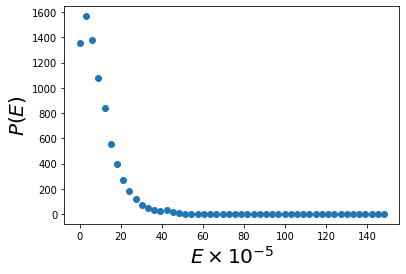

In [36]:
import numpy as onp
import matplotlib.pyplot as plt


def format_plot(x, y):
    plt.xlabel(x, fontsize=20)
    plt.ylabel(y, fontsize=20)


bubble_energies = jax.pmap(lambda x: jax.lax.all_gather(x, "i"), axis_name="i")(bubble_energies)[0]
counts, bins = onp.histogram(bubble_energies, bins=50)
plt.plot(bins[:-1] * 10**5, counts, "o")
format_plot("$E\\times 10 ^{-5}$", "$P(E)$")
plt.savefig("plot.png")